In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

In [4]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
gs = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [5]:
train.info()
print('='*40)
test.info()
print('='*40)
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

***Checking Missing values***

In [6]:
def missing_summary(df):
  null = df.isnull().sum()
  not_null = df.notnull().sum()
  return pd.DataFrame({'Total_missing':null,'missing %': round((null/(null+not_null))*100,2),'Total_non_missing':not_null,'total_records':null+not_null})

In [7]:
# Summary of test & train 
print('training_data : \n',missing_summary(train),'\n','='*40,'\n','test data : \n',missing_summary(test))

training_data : 
              Total_missing  missing %  Total_non_missing  total_records
PassengerId              0       0.00                891            891
Survived                 0       0.00                891            891
Pclass                   0       0.00                891            891
Name                     0       0.00                891            891
Sex                      0       0.00                891            891
Age                    177      19.87                714            891
SibSp                    0       0.00                891            891
Parch                    0       0.00                891            891
Ticket                   0       0.00                891            891
Fare                     0       0.00                891            891
Cabin                  687      77.10                204            891
Embarked                 2       0.22                889            891 
 test data : 
              Total_missing  mi

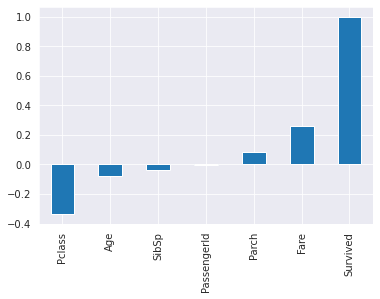

In [8]:
train.corr()['Survived'].sort_values().plot(kind='bar')
plt.show()

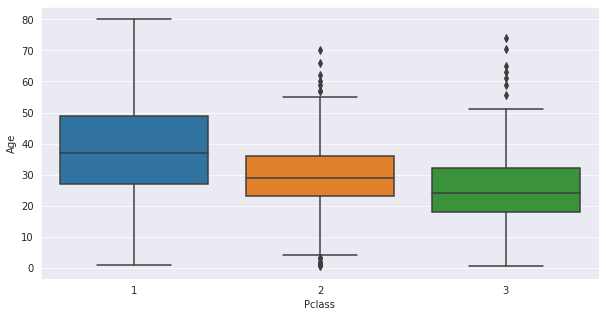

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Pclass' , y = 'Age', data=train)
plt.show()

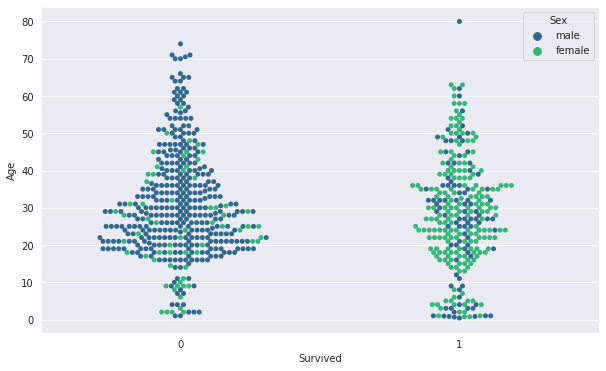

In [10]:
plt.figure(figsize=(10,6))
sns.swarmplot(y='Age', x='Survived',hue='Sex', data=train,palette='viridis')
plt.show()

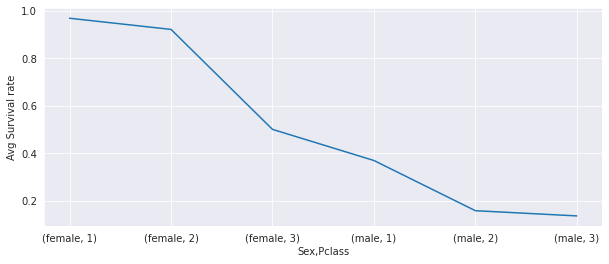

In [11]:
train.groupby(['Sex','Pclass'])['Survived'].mean().plot(figsize=(10,4))
plt.ylabel('Avg Survival rate')
plt.show()

***Missing value treatement - Training data***

In [12]:
train.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [13]:
for i in train['Pclass'].unique():
  train[train['Pclass'] == i] = train[train['Pclass'] == i].fillna({'Age': train[train['Pclass'] == i]['Age'].dropna().median()})

In [14]:
train.groupby('Pclass')['Age'].mean()

Pclass
1    38.062130
2    29.825163
3    24.824684
Name: Age, dtype: float64

***Missing value treatement - test data***

In [15]:
print('mean of age by :', test.groupby('Pclass')['Age'].mean(),'\n\n',
      '='*40,'\n\n'
      'mean of fare by :', test.groupby('Pclass')['Fare'].mean()
      )

mean of age by : Pclass
1    40.918367
2    28.777500
3    24.027945
Name: Age, dtype: float64 


mean of fare by : Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64


In [16]:
for i in test['Pclass'].unique():
  test[test['Pclass'] == i] = test[test['Pclass'] == i].fillna({'Age': test[test['Pclass'] == i]['Age'].dropna().median()})
  test[test['Pclass'] == i] = test[test['Pclass'] == i].fillna({'Fare': test[test['Pclass'] == i]['Fare'].mean()})

In [17]:
print('mean of age by :', test.groupby('Pclass')['Age'].mean(),'\n\n',
      '='*40,'\n\n'
      'mean of fare by :', test.groupby('Pclass')['Fare'].mean()
      )

mean of age by : Pclass
1    41.009346
2    28.655054
3    24.018716
Name: Age, dtype: float64 


mean of fare by : Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64


***Summary of test & train data***

In [18]:
print('training_data : \n',missing_summary(train),'\n','='*40,'\n','test data : \n',missing_summary(test))

training_data : 
              Total_missing  missing %  Total_non_missing  total_records
PassengerId              0       0.00                891            891
Survived                 0       0.00                891            891
Pclass                   0       0.00                891            891
Name                     0       0.00                891            891
Sex                      0       0.00                891            891
Age                      0       0.00                891            891
SibSp                    0       0.00                891            891
Parch                    0       0.00                891            891
Ticket                   0       0.00                891            891
Fare                     0       0.00                891            891
Cabin                  687      77.10                204            891
Embarked                 2       0.22                889            891 
 test data : 
              Total_missing  mi

In [19]:
train['Title'] = train['Name'].str.split(',').str[1].str.split().str[0]
test['Title'] = test['Name'].str.split(',').str[1].str.split().str[0]

In [20]:
train['Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Jonkheer.      1
the            1
Sir.           1
Ms.            1
Lady.          1
Don.           1
Mme.           1
Capt.          1
Name: Title, dtype: int64

In [21]:
test['Title'].value_counts()

Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Ms.          1
Dona.        1
Dr.          1
Name: Title, dtype: int64

In [22]:
title_mapping = {'Mr.':1,'Miss.':2,'Mrs.':3,'Master.':4,'Rev.':5,'Col.':6,'Ms.':7,'Dr.':8,'Dona.':9, 'Don.':9}

In [23]:
train['Title'] = train['Title'].map(title_mapping)
test['Title'] = test['Title'].map(title_mapping)

In [24]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title           10
dtype: int64

In [25]:
# Droping column which is not required
train = train.drop('Cabin', axis=1)
test = test.drop('Cabin', axis=1)

In [26]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [27]:
#Deleting the records of training dataset where Embarked is missing
train.dropna(axis=0,inplace=True)

In [28]:
# correlation with respect to target variable
train.corr()['Survived'].sort_values()

Pclass        -0.330982
Age           -0.054210
SibSp         -0.032602
PassengerId   -0.007917
Parch          0.088554
Fare           0.252607
Title          0.365318
Survived       1.000000
Name: Survived, dtype: float64

In [29]:
# we already classified name and we are droping columns from both dataset
train = train.drop(['Name','Ticket'],axis=1)
test = test.drop(['Name','Ticket'],axis=1)

In [30]:
print('test dataset:\n',test.dtypes)
print('='*40)
print('train dataset:\n',train.dtypes)

test dataset:
 PassengerId      int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Title            int64
dtype: object
train dataset:
 PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Title          float64
dtype: object


In [31]:
train['Title'] = train['Title'].astype('int64')

### Converting categorical variable into dummy/indicator variables

In [32]:
X = pd.get_dummies(data=train.drop('Survived',axis=1),columns=['Sex','Embarked','Pclass','Title'],drop_first=True)
y = train['Survived'].values

***spliting train & test data into 70:30***

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [34]:
X_train.head()

,PassengerId,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9
340,341,2.00,1,1,26.0000,1,0,1,1,0,0,0,1,0,0,0,0,0
803,804,0.42,0,1,8.5167,1,0,0,0,1,0,0,1,0,0,0,0,0
267,268,25.00,1,0,7.7750,1,0,1,0,1,0,0,0,0,0,0,0,0
837,838,24.00,0,0,8.0500,1,0,1,0,1,0,0,0,0,0,0,0,0
65,66,24.00,1,1,15.2458,1,0,0,0,1,0,0,1,0,0,0,0,0


In [35]:
test_sample = pd.get_dummies(data=test,columns=['Sex','Embarked','Pclass','Title'],drop_first=True)

In [36]:
test_sample.head()

,PassengerId,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9
0,892,34.5,0,0,7.8292,1,1,0,0,1,0,0,0,0,0,0,0,0
1,893,47.0,1,0,7.0000,0,0,1,0,1,0,1,0,0,0,0,0,0
2,894,62.0,0,0,9.6875,1,1,0,1,0,0,0,0,0,0,0,0,0
3,895,27.0,0,0,8.6625,1,0,1,0,1,0,0,0,0,0,0,0,0
4,896,22.0,1,1,12.2875,0,0,1,0,1,0,1,0,0,0,0,0,0


In [37]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):

    if train == True:
        '''
        performance of training data
        '''
 
        print("Train Result:")
        print("="*60)
        print("\n")
        print("Accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train.ravel(), cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        print("\n\n")
        
    else:
        '''
         performance of test data
        '''
        print("Test Result:") 
        print("="*60)
        print("\n")
        print("Accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    
        

In [38]:
scale = StandardScaler()

X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [39]:
model_classifiers = {'K-Nearest_Neighbors': KNeighborsClassifier(),
                     'SVM'                : SVC(),
                     'LogisticRegression' : LogisticRegression(),
                     'Gaussian_Process'   : GaussianProcessClassifier(),
                     'Gradient_Boosting'  : GradientBoostingClassifier(),
                     'Decision_Tree'      : DecisionTreeClassifier(),
                     'Extra_Trees'        : ExtraTreesClassifier(),
                     'Random_Forest'      : RandomForestClassifier(),
                     'Neural_Net'         : MLPClassifier(alpha=1, max_iter=1000),
                     'AdaBoost'           : AdaBoostClassifier(),
                     'XGBoost'            : XGBClassifier(random_state=42)}

In [40]:
def model_compare(x_train_df,y_train_df,x_test_df,y_test_df,model_list):
  return pd.DataFrame({'Model Name'    : [ i for i in model_list.keys()],
                       'Training Score': [accuracy_score(y_train_df,i.fit(x_train_df,y_train_df).predict(x_train_df)) for i in model_list.values()],
                       'Test Score'    : [accuracy_score(y_test_df,i.fit(x_train_df,y_train_df).predict(x_test_df)) for i in model_list.values()]
                       }
                      )

## Compare Models

In [41]:
model_compare(X_train,y_train,X_test,y_test,model_classifiers)

,Model Name,Training Score,Test Score
0,K-Nearest_Neighbors,0.840650,0.795455
1,SVM,0.847154,0.840909
2,LogisticRegression,0.827642,0.844697
3,Gaussian_Process,0.900813,0.814394
4,Gradient_Boosting,0.908943,0.821970
5,Decision_Tree,1.000000,0.715909
6,Extra_Trees,1.000000,0.818182
7,Random_Forest,0.998374,0.837121
8,Neural_Net,0.834146,0.840909
9,AdaBoost,0.837398,0.776515


## Apply Models

***Applying Logistic Regression on train data***

In [42]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [43]:
print_score(logreg, X_train, y_train, X_test, y_test, train=True)
print_score(logreg, X_train, y_train, X_test, y_test, train=False)

Train Result:


Accuracy score: 0.8276

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.88      0.87       389
           1       0.78      0.73      0.76       226

    accuracy                           0.83       615
   macro avg       0.82      0.81      0.81       615
weighted avg       0.83      0.83      0.83       615


Confusion Matrix: 
 [[343  46]
 [ 60 166]]

Average Accuracy: 	 0.8145
Accuracy SD: 		 0.0444



Test Result:


Accuracy score: 0.8447

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       157
           1       0.85      0.75      0.80       107

    accuracy                           0.84       264
   macro avg       0.85      0.83      0.84       264
weighted avg       0.85      0.84      0.84       264


Confusion Matrix: 
 [[143  14]
 [ 27  80]]



Applying SVM on train data

In [44]:
svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [45]:
print_score(svm, X_train, y_train, X_test, y_test, train=True)
print_score(svm, X_train, y_train, X_test, y_test, train=False)

Train Result:


Accuracy score: 0.8472

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.95      0.89       389
           1       0.88      0.68      0.77       226

    accuracy                           0.85       615
   macro avg       0.86      0.81      0.83       615
weighted avg       0.85      0.85      0.84       615


Confusion Matrix: 
 [[368  21]
 [ 73 153]]

Average Accuracy: 	 0.8227
Accuracy SD: 		 0.0310



Test Result:


Accuracy score: 0.8409

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.96      0.88       157
           1       0.92      0.66      0.77       107

    accuracy                           0.84       264
   macro avg       0.86      0.81      0.82       264
weighted avg       0.85      0.84      0.83       264


Confusion Matrix: 
 [[151   6]
 [ 36  71]]



## Apply model on test data


### gs = gender_submission.csv & predicted_test = predicted value of test.csv




In [46]:
test_sample = scale.transform(test_sample)

In [47]:
Survived = svm.predict(test_sample)

In [48]:
predicted_test = pd.concat([test,pd.DataFrame({'Survived':Survived.tolist()})],axis=1)[['PassengerId','Survived']].sort_values('PassengerId')

In [49]:
print('Confusion Matrix:\n\n', confusion_matrix(gs.Survived,predicted_test.Survived),
      '\n\n','='*40,'\n'
      'Accuracy Score:\n\n',accuracy_score(gs.Survived,predicted_test.Survived))

Confusion Matrix:

 [[250  16]
 [ 17 135]] 

Accuracy Score:

 0.9210526315789473


In [51]:
predicted_test.to_csv('submission.csv', index=False)